<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/Colab_timeseries_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - timeseries package for fastai v2

In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install torch>=1.2.0
!pip install torchvision>=0.5
!pip install pillow 
os._exit(00)

     |████████████████████████████████| 143kB 15.0MB/s 
     |████████████████████████████████| 63.2MB 51kB/s 
     |████████████████████████████████| 1.4MB 23.3MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 184kB 57.1MB/s 
     |████████████████████████████████| 460kB 51.7MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 71kB 12.7MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 734.6MB 23kB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 10.2MB 1.4MB/s 
ERROR: fastai2 0.0.10 has requirement torchvision>=0.5,

In [3]:
!pip install git+https://github.com/ai-fast-track/timeseries.git

  Cloning https://github.com/ai-fast-track/timeseries.git to /tmp/pip-req-build-bcs12bs9
  Running command git clone -q https://github.com/ai-fast-track/timeseries.git /tmp/pip-req-build-bcs12bs9
     |████████████████████████████████| 4.0MB 11.3MB/s 
  Created wheel for timeseries: filename=timeseries-0.0.2-cp36-none-any.whl size=349041 sha256=3d8d6c9b8d39e214ee73b9497fc89a7a35b97291c35b16820fcfbace4cf0ac69
  Stored in directory: /tmp/pip-ephem-wheel-cache-r9np_jrk/wheels/35/01/01/4fdd69c029e9537c05914ee49520e9d36edaa9b2636f089bfc
Successfully built timeseries
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2


In [1]:
# !pip list

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai2.basics import *
from timeseries.all import *

In [5]:
!ls /root/.fastai/data

ls: cannot access '/root/.fastai/data': No such file or directory


In [21]:
url = URLs_TS.NATOPS
url, URLs_TS.path(url, c_key='data')

('http://www.timeseriesclassification.com/Downloads/NATOPS.zip',
 Path('/root/.fastai/data/NATOPS.zip'))

In [22]:
# url = 'http://www.timeseriesclassification.com/Downloads/LSST.zip'
path2 = untar_data(URLs_TS.NATOPS)
path2, path2.parent

(Path('/root/.fastai/data/NATOPS'), Path('/root/.fastai/data'))

In [23]:
path_data = Config().data
path_data, path_data.ls()

(Path('/root/.fastai/data'),
 (#72) [Path('/root/.fastai/data/NATOPSDimension22_TRAIN.arff'),Path('/root/.fastai/data/NATOPSDimension17_TEST.arff'),Path('/root/.fastai/data/NATOPSDimension2_TRAIN.arff'),Path('/root/.fastai/data/NATOPS_TRAIN.ts'),Path('/root/.fastai/data/NATOPSDimension6_TEST.arff'),Path('/root/.fastai/data/NATOPSDimension8_TEST.arff'),Path('/root/.fastai/data/NATOPSDimension1_TRAIN.arff'),Path('/root/.fastai/data/LSST.JPG'),Path('/root/.fastai/data/NATOPSDimension21_TEST.arff'),Path('/root/.fastai/data/NATOPSDimension15_TEST.arff')...])

In [0]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'

In [0]:
# path = download_unzip_data_UCR(dsname=dsname)
# path.ls()

In [26]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path_data/fname_train, path_data/fname_test]
fnames

[Path('/root/.fastai/data/NATOPS_TRAIN.arff'),
 Path('/root/.fastai/data/NATOPS_TEST.arff')]

In [27]:
data = TSData()
train_x, train_y = data.load(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_TRAIN', 'NATOPS_TEST']
 Filenames: \                   [Path('/root/.fastai/data/NATOPS_TRAIN.arff'), Path('/root/.fastai/data/NATOPS_TEST.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels: \         24
 Sequence Length: 51


In [0]:
!ls /root/.fastai/data/

In [0]:
items = data.get_items()

In [31]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
splits

((#288) [304,281,114,329,115,130,338,294,94,310...],
 (#72) [222,27,96,253,274,35,160,172,302,146...])

In [0]:
bs = 128                            
# Normalize at batch time
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
# tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

In [33]:
default_device()

device(type='cuda', index=0)

In [0]:

dls = TSDataLoaders.from_files(fnames=fnames, batch_tfms=batch_tfms,device=default_device())

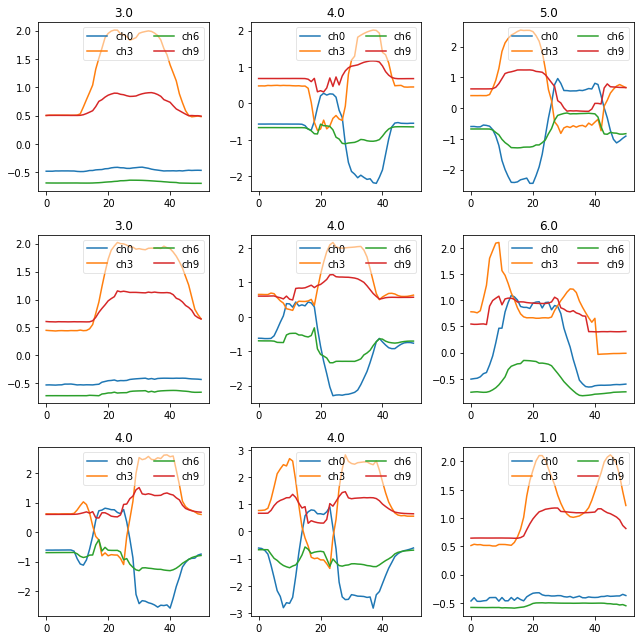

In [36]:
dls.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

# Train Model

In [38]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= len(dls.vocab) 
c_in,c_out

(24, 6)

In [40]:
model = create_inception(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(24, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(24, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(24, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(24, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39

In [42]:
#Learner
opt_func = partial(Adam, lr=3e-3, wd=0.01)     
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 24 x 51'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 51         29,952     True      
________________________________________________________________
Conv1d               64 x 32 x 51         14,592     True      
________________________________________________________________
Conv1d               64 x 32 x 51         6,912      True      
________________________________________________________________
MaxPool1d            64 x 24 x 51         0          False     
________________________________________________________________
Conv1d               64 x 32 x 51         768        True      
________________________________________________________________
BatchNorm1d          64 x 128 x 51        256        True      
________________________________________________________________
ReLU                 64 x 128 x 51        0          False     
_______________________________________________________

(0.012022644281387329, 0.00013182566908653826)

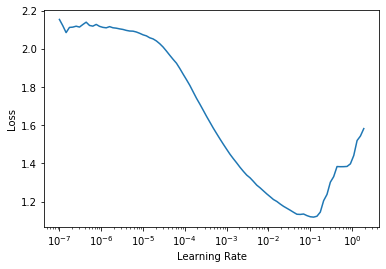

In [43]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [46]:
#lr_max=1e-3
epochs=30; lr_max=lr_steep;  pct_start=.7; moms=(0.95,0.85,0.95); wd=1e-2
learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
# learn.fit_one_cycle(epochs, lr_max=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.515635,0.660134,0.847222,00:00
1,0.513212,0.660676,0.847222,00:00
2,0.513360,0.661923,0.847222,00:00
3,0.516117,0.660020,0.847222,00:00
4,0.516932,0.655791,0.847222,00:00
5,0.515955,0.647752,0.875000,00:00
6,0.513149,0.647183,0.875000,00:00
7,0.511271,0.654351,0.847222,00:00
8,0.507244,0.645913,0.861111,00:00
9,0.503368,0.651823,0.861111,00:00


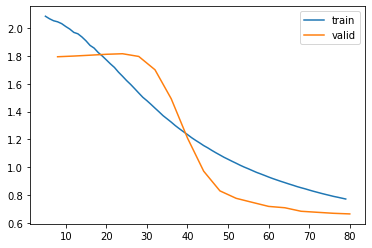

In [45]:
learn.recorder.plot_loss()